Dataset preview:
     size_sqft  num_bedrooms  num_bathrooms  age_years  location_score  \
0  2248.357077             3              3         17        3.007810   
1  1930.867849             1              3          9        1.508641   
2  2323.844269             2              4         27        1.930554   
3  2761.514928             2              1         10        4.883573   
4  1882.923313             4              1         32        3.069265   

  house_size  
0     Medium  
1     Medium  
2     Medium  
3      Large  
4     Medium  

Starting Grid Search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Grid Search completed in 8.48 seconds

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9150
Test Set Accuracy (Tuned): 0.9217
✅ Model is a GOOD FIT (generalizing well).

Classification Report (Tuned Model):
              precision    recall  f1-score   sup

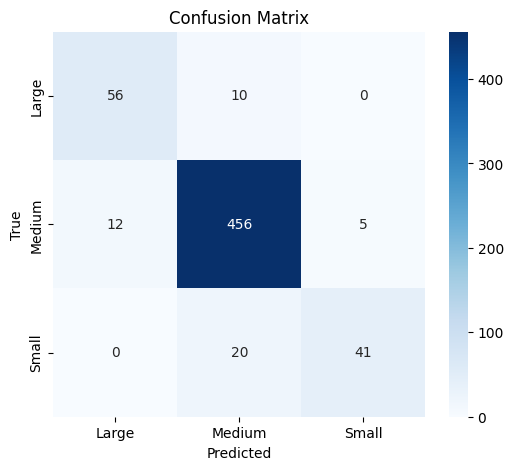

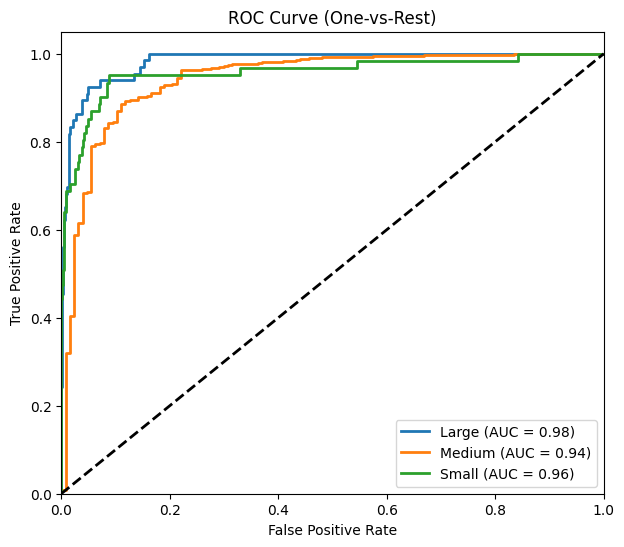

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# --------------------------
# Generate synthetic dataset
# --------------------------
np.random.seed(42)
n_samples = 2000

# Features
size_sqft = np.random.normal(2000, 500, n_samples).clip(600, 4000)
num_bedrooms = np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.25, 0.4, 0.2, 0.05])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.2, 0.4, 0.3, 0.1])
age_years = np.random.randint(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Price formula (simplified)
price = (
    size_sqft * 150 +
    num_bedrooms * 10000 +
    num_bathrooms * 7000 +
    (50 - age_years) * 1000 +
    location_score * 5000 +
    np.random.normal(0, 20000, n_samples)
)

# Categorize into classes
labels = []
for p in price:
    if p < 300000:
        labels.append("Small")
    elif p < 500000:
        labels.append("Medium")
    else:
        labels.append("Large")

# Create DataFrame
data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'house_size': labels
})

print("Dataset preview:")
print(data.head())

# --------------------------
# Split dataset
# --------------------------
X = data.drop('house_size', axis=1)
y = data['house_size']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------
# Hyperparameter tuning
# --------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

print("\nStarting Grid Search...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"Grid Search completed in {end_time - start_time:.2f} seconds")

# --------------------------
# Evaluation
# --------------------------
print(f"\nBest Parameters: {grid_search.best_params_}")
cv_score = grid_search.best_score_
print(f"Best Cross-Validation Score: {cv_score:.4f}")

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"Test Set Accuracy (Tuned): {test_accuracy:.4f}")

# Overfit / Underfit / Good fit check
if test_accuracy < cv_score - 0.05:
    print("⚠️ Model is likely OVERFITTING (train > test).")
elif test_accuracy > cv_score + 0.05:
    print("⚠️ Model may be UNDERFITTING (unstable CV).")
else:
    print("✅ Model is a GOOD FIT (generalizing well).")

# Classification report
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred_tuned, labels=best_model.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --------------------------
# ROC Curve & AUC
# --------------------------
# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_score = best_model.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(7, 6))
for i, class_name in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


<h1>Results Analysis and Interpretation</h1>

In [10]:
import pandas as pd

# Get predictions for the test set
test_predictions = best_model.predict(X_test)

# Combine input features, actual prices, and predicted prices into a single DataFrame
results = X_test.copy()
results['Actual Price'] = y_test.values
results['Predicted Price'] = test_predictions

# Display the first few rows of the results
print("Full DataFrame with Input Features, Actual Prices, and Predicted Prices:")
print(results.head().to_string(index=False))

Full DataFrame with Input Features, Actual Prices, and Predicted Prices:
  size_sqft  num_bedrooms  num_bathrooms  age_years  location_score Actual Price Predicted Price
2319.025551             3              2         32        7.426783       Medium          Medium
2379.484610             3              2          0        4.654739       Medium          Medium
2106.989955             2              3          4        6.300424       Medium          Medium
1976.539711             4              2         14        6.266095       Medium          Medium
2830.629607             3              2          2        8.887788        Large           Large


<h1>Model Saving</h1>

In [3]:
import joblib

# Save the trained model to a file
model_filename = "model/final_random_forest_model.pkl"
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to model/final_random_forest_model.pkl


<h1>Load Model </h1>

In [4]:
import joblib

# Load the trained model from the file
model_filename = "model/final_random_forest_model.pkl"
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model/final_random_forest_model.pkl


<h1>Prediction</h1>

In [6]:
# Example new data for prediction
new_data = pd.DataFrame({
    'size_sqft': [1500, 2500],
    'num_bedrooms': [3, 4],
    'num_bathrooms': [2, 3],
    'age_years': [10, 5],
    'location_score': [8, 9]
})

# Make predictions using the tuned/best model
new_predictions = best_model.predict(new_data)

# Display predictions
for i, label in enumerate(new_predictions):
    print(f"Prediction for house {i + 1}: {label}")


Prediction for house 1: Medium
Prediction for house 2: Large


In [8]:
import numpy as np
import pandas as pd

# Example new data for prediction
new_data = pd.DataFrame({
    'size_sqft': [1500, 2500],
    'num_bedrooms': [3, 4],
    'num_bathrooms': [2, 3],
    'age_years': [10, 5],
    'location_score': [8, 9]
})

# Make predictions using the trained model
new_predictions = best_model.predict(new_data)

# Add predictions as a new column
new_data['Predicted House Size'] = new_predictions

# Display neatly
print("\nInput Data with Predicted House Size:")
print(new_data.to_string(index=False))



Input Data with Predicted House Size:
 size_sqft  num_bedrooms  num_bathrooms  age_years  location_score Predicted House Size
      1500             3              2         10               8               Medium
      2500             4              3          5               9                Large


<h1>Results Analysis from a Model</h1>

In [9]:
import pandas as pd

# Get predictions for the test set
test_predictions = loaded_model.predict(X_test)

# Combine input features, actual prices, and predicted prices into a single DataFrame
results = X_test.copy()
results['Actual Price'] = y_test.values
results['Predicted Price'] = test_predictions

# Display the first few rows of the results
print("Full DataFrame with Input Features, Actual Prices, and Predicted Prices:")
print(results.head().to_string(index=False))

Full DataFrame with Input Features, Actual Prices, and Predicted Prices:
  size_sqft  num_bedrooms  num_bathrooms  age_years  location_score Actual Price Predicted Price
2319.025551             3              2         32        7.426783       Medium          Medium
2379.484610             3              2          0        4.654739       Medium          Medium
2106.989955             2              3          4        6.300424       Medium          Medium
1976.539711             4              2         14        6.266095       Medium          Medium
2830.629607             3              2          2        8.887788        Large           Large
